<a href="https://colab.research.google.com/github/Badslam/time-series/blob/main/LSTM(Syntax_Teh_Oi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import pacf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier 
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Load Data
url = 'https://raw.githubusercontent.com/Badslam/time-series/main/Umum%20.csv'
data = pd.read_csv(url)

In [5]:
#Preprocessing and Splitting
dataset=data['Terakhir'].iloc[0:2032].values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.80)
test_size=len(dataset)-train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]


In [6]:
#Create Dataset Function

def create_dataset(dataset,look_back=1):
    X,Y=[],[]
    for i in range (len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        X.append(a)
        Y.append(dataset[i+look_back,0])
    return np.array(X),np.array(Y)

In [7]:
#Lookback
look_back=1
X_train, Y_train=create_dataset(train,look_back)
X_test, Y_test=create_dataset(test,look_back)
#reshape input to be [samples, time steps, features]
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [8]:
#TrainTest
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
#Model Training
model=Sequential()
model.add(LSTM(5,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='tanh',kernel_initializer='glorot_uniform',bias_initializer='zero',
                use_bias=True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam')
history=model.fit(X_train,Y_train,epochs=10,batch_size=1,validation_data=(X_test,Y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/10
437/437 [==============================] - 3s 3ms/step - loss: 0.0701 - val_loss: 0.0449
Epoch 2/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0279
Epoch 3/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0320 - val_loss: 0.0202
Epoch 4/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0139
Epoch 5/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0096
Epoch 6/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 7/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 8/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 9/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 10/10
437/437 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0040

In [10]:
#Predict
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#invert prediction
train_predict=scaler.inverse_transform(train_predict)
Y_train=scaler.inverse_transform([Y_train])
test_predict=scaler.inverse_transform(test_predict)
Y_test=scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:',
      mean_absolute_error(Y_train[0],train_predict[:,0]))
print('Train Root Mean Squared Error:',
      np.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))
print('Test Mean Absolute Error:',
      mean_absolute_error(Y_test[0],test_predict[:,0]))
print('Test Root Mean Squared Error:',
      np.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))

Train Mean Absolute Error: 123.53341763634357
Train Root Mean Squared Error: 156.12759819436556
Test Mean Absolute Error: 149.41899217783168
Test Root Mean Squared Error: 165.9337026184446


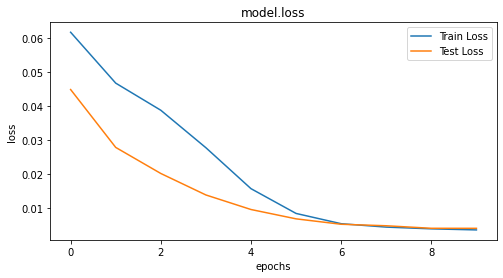

In [11]:
#Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model.loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

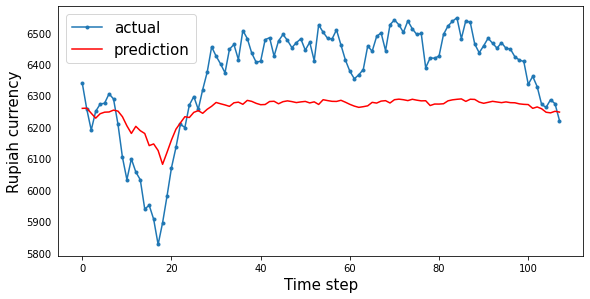

In [15]:
#Plot Prediction
aa=[x for x in range(108)]
plt.figure(figsize=(8,4))
plt.plot(aa,Y_test[0][:108],marker='.',label="actual")
plt.plot(aa,test_predict[:,0][:108],'r',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Rupiah currency',size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [16]:
#Mean Absolute Error
def mean_absolute_percentage_error (Y_test,test_predict) :
    Y_test, test_predict=np.array(Y_test),np.array(test_predict)
    return np.mean(np.abs((Y_test-test_predict)/Y_test))*100
mean_absolute_percentage_error (Y_test,test_predict)

2.7578414239349223